# Feature Extraction from Speech Data with OpenSMILE and GeMaps config
## Audio data collected in the EEG MIST paradigm

In [1]:
import glob
import os
import re
import subprocess
from io import StringIO
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.io import arff
from tqdm.auto import tqdm

Jonas = 0 # Set Jonas to 1 if Jonas

In [10]:
# Set Data Path
# DATA_PATH = "C:/Users/mitch/OneDrive - UGent/UGent/Projects/5. VOP project/Voice_and_App/"
if(Jonas == 1):
    BASE_PATH = "/users/jonvdrdo/jonas/data/aaa_contextaware/raw/uz_study/"
    FEATURES_PATH = '' 
    DATA_PATH = BASE_PATH + "aligned_data"
elif(Jonas == 0):
    BASE_PATH = "D:/Data/EEG_Study_1/" # Go check 1_audio_preprocess.py
    DATA_PATH = BASE_PATH + "aligned_data"
    # Set OpenSMILE Config Path
    OPENSMILE_CONFIG = '"C:/Users/mitch/OneDrive - UGent/UGent/Topics/Facial/OpenSmile/opensmile-2.3.0/config/gemaps/GeMAPSv01a.conf"'

    FEATURES_PATH = DATA_PATH + "/features_gemaps/"
    RAW_PATH = "C:/Users/mitch/OneDrive - UGent/UGent/Projects/2. Vanhollebeke et al/Data/Actual/Audio_Jonas"




# Extract features

## THIS ONE IS IF GETTING DATA FROM ALIGNED_DATA

In [11]:
## Only run this cell ONCE (set to False if exctracted)

# THIS ONE IS IF GETTING DATA FROM ALIGNED_DATA
if False:
    # Create paths if not existed
    Path(FEATURES_PATH).mkdir(parents=True, exist_ok=True)

    def extract(source, destination):
        # Generate extraction command
        cmd = "C:/Users/mitch/OneDrive/Documents/UGent/Topics/Facial/OpenSmile/opensmile-2.3.0/SMILExtract_Release -C {} -I {} -O {}".format(
            OPENSMILE_CONFIG, source, destination
        )
        #     print(cmd)
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
        p.wait()

    for wav_file in tqdm(glob.glob(DATA_PATH + "/*/audio/*.wav")):
        participant_dir = wav_file.split("/")[-1]
        participant_dir = participant_dir.split("\\")[1]
        filename = re.findall(r"udio\\(.+).wav", wav_file)[
            0
        ]  # file name excluding .wav
        #         filenum = re.findall(r'occ_(.+?).wav',wav_file)[0] # file number
        filenum = filename[
            filename.find("occ_") + 4 : filename.find("occ_") + 6
        ]  # else it cant find exceptions like 99-2 or something

        if (
            filenum == "99"
        ):  # Something went wrong in the naming of the inital files and this is a quick fix
            filename = (
                filename[: filename.find("occ_") + 4]
                + "9"
                + filename[filename.find("occ_") + 6 :]
            )  # replace 99 by 9 but keep the rest

        out_path = FEATURES_PATH + "/" + participant_dir + "/" + filename + ".arff"

        wav_file = '"' + wav_file.replace(os.sep, "/") + '"'
        out_path = '"' + out_path + '"'

        Path(FEATURES_PATH + "/" + participant_dir + "/").mkdir(
            parents=True, exist_ok=True
        )

        extract(wav_file, out_path)
#         break
#     print(out_path)

## THIS ONE IS IF GETTING DATA FROM LOCAL JONAS_DATA

In [12]:
## Only run this cell ONCE (set to False if exctracted)
count = 0
# THIS ONE IS IF GETTING DATA FROM LOCAL DATA
if False:
    # Create paths if not existed
    Path(FEATURES_PATH).mkdir(parents=True, exist_ok=True)

    def extract(source, destination):
        # Generate extraction command
        cmd = "C:/Users/mitch/OneDrive/Documents/UGent/Topics/Facial/OpenSmile/opensmile-2.3.0/SMILExtract_Release -C {} -I {} -O {}".format(
            OPENSMILE_CONFIG, source, destination
        )
        #     print(cmd)
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
        p.wait()

    for wav_file in tqdm(glob.glob(RAW_PATH + "/*/sentences*.wav")):
        participant_dir = re.findall(r"Jonas\\(.+?)\\sentences", wav_file)[0]
        filenum = re.findall(r"occ_(.+?).wav", wav_file)[0]

        if (
            filenum == "99"
        ):  # Something went wrong in the naming of the inital files and this is a quick fix
            filename = "sentences_occ_" + "9"
        else:
            filename = "sentences_occ_" + filenum

        out_path = FEATURES_PATH + "/" + participant_dir + "/" + filename + ".arff"

        wav_file = '"' + wav_file.replace(os.sep, "/") + '"'
        out_path = '"' + out_path + '"'

        Path(FEATURES_PATH + "/" + participant_dir + "/").mkdir(
            parents=True, exist_ok=True
        )

        extract(wav_file, out_path)
#         print(f'in file is: ', wav_file, ' and out file is: ', out_path)
#         break
#     print(out_path)

# Load all Marloeses and compile into comprehensive df

In [13]:
if False:  # Only used once to get everything into a nice .csv
    from arff2pandas import a2p

    dataMarloes = pd.DataFrame()
    for arff_file in tqdm(glob.glob(FEATURES_PATH + "/*/sentences*.arff")):
        participantNum = int(
            re.findall(r"features_gemaps\\(.+?)\\sentences", arff_file)[0]
        )
        try:
            fileNum = int(re.findall(r"sentences_occ_(.+?).arff", arff_file)[0])

            with open(arff_file) as f:
                df = a2p.load(f)
                df.insert(
                    0, "participantNum", participantNum
                )  # Add column for participant Number
                df.insert(1, "fileNum", fileNum)  # Add column for file Number
                dataMarloes = dataMarloes.append(df)
        except:
            print(
                f"Something wrong with file name of participant: ",
                participantNum,
                "File number: ",
                fileNum + 1,
            )

    dataMarloes.to_csv(
        FEATURES_PATH + "marloesFeaturesCompiled.csv", encoding="utf-8", index=False
    )

dataMarloes = pd.read_csv(
    FEATURES_PATH + "marloesFeaturesCompiled.csv"
)  # Read .csv file

dataMarloes = dataMarloes[
    dataMarloes["fileNum"] != 9
]  # For now remove every first Marloes from the dataframe - we seem not to have any SAMs for these.

# Rename column names because with the .arff files it got loaded weirdly
maxX = len(dataMarloes.columns)
count = 0

while count < maxX:
    if count > 2:  # Skip a few
        name = dataMarloes.columns[count]
        name = name[
            0 : name.find("@NUMERIC")
        ]  # Find where @NUMERIC starts and get everything in front of it
        dataMarloes.rename(
            columns={dataMarloes.columns[count]: name}, inplace=True
        )  # Rename columns
    count = count + 1

# Add explicit responses from appData.csv

In [14]:
if False:  # Only used once to get everything into a nice .csv
    dataSAM = pd.DataFrame()

    for csv_file in tqdm(glob.glob(DATA_PATH + "/*/audio/appData.csv")):
        participantNum = csv_file.split("/")[-1]
        participantNum = int(participantNum.split("\\")[1])

        temp = pd.read_csv(csv_file)
        for i in range(0, 9):
            d = {
                "participantNum": participantNum,
                "fileNum": i,
                "arousal": temp["arousals_" + str(i)],
                "valence": temp["valences_" + str(i)],
                "dominance": temp["dominances_" + str(i)],
            }
            df = pd.DataFrame(data=d)
            dataSAM = dataSAM.append(df)

    dataSAM.to_csv(
        FEATURES_PATH + "SAMsCompiled.csv", encoding="utf-8", index=False
    )  # Write CSV

dataSAM = pd.read_csv(FEATURES_PATH + "SAMsCompiled.csv")  # Read CSV
data = pd.merge(
    dataMarloes, dataSAM, on=["participantNum", "fileNum"]
)  # Put marloes and SAMS together for all complete sets

In [16]:
data = data[
    ~np.logical_and(
        data["participantNum"] == 1,
        np.logical_or(data["fileNum"] == 1, data["fileNum"] == 3),
    )
]  # PPT1

data = data[data["participantNum"] != 2]  # PPT2

data = data[
    ~np.logical_and(
        data["participantNum"] == 3,
        np.logical_or(data["fileNum"] == 0, data["fileNum"] == 8),
    )
]  # PPT3

data = data[~np.logical_and(data["participantNum"] == 5, data["fileNum"] == 8)]  # PPT5
data = data[~np.logical_and(data["participantNum"] == 6, data["fileNum"] == 7)]  # PPT6
data = data[~np.logical_and(data["participantNum"] == 8, data["fileNum"] == 8)]  # PPT8
data = data[~np.logical_and(data["participantNum"] == 9, data["fileNum"] == 3)]  # PPT9
data = data[
    ~np.logical_and(data["participantNum"] == 17, data["fileNum"] == 6)
]  # PPT17
data = data[data["participantNum"] != 24]  # PPT24
data = data[data["participantNum"] != 25]  # PPT25
data = data[
    ~np.logical_and(
        data["participantNum"] == 29,
        np.logical_or.reduce(
            (data["fileNum"] == 2, data["fileNum"] == 4, data["fileNum"] == 8)
        ),
    )
]
data = data[
    ~np.logical_and(data["participantNum"] == 31, data["fileNum"] == 2)
]  # PPT31
data = data[
    ~np.logical_and(
        data["participantNum"] == 35,
        np.logical_or.reduce(
            (
                data["fileNum"] == 0,
                data["fileNum"] == 3,
                data["fileNum"] == 5,
                data["fileNum"] == 6,
                data["fileNum"] == 7,
            )
        ),
    )
]  # PPT35
data = data[
    ~np.logical_and(data["participantNum"] == 36, data["fileNum"] == 8)
]  # PPT36
data = data[data["participantNum"] != 45]  # PPT45
data = data[
    ~np.logical_and(data["participantNum"] == 48, data["fileNum"] == 5)
]  # PPT48
data = data[data["participantNum"] != 53]  # PPT53
data = data[
    ~np.logical_and(data["participantNum"] == 60, data["fileNum"] == 0)
]  # PPT60
data = data[
    ~np.logical_and(data["participantNum"] == 61, data["fileNum"] == 7)
]  # PPT61
data = data[data["participantNum"] != 62]  # PPT62
# data = data[data['participantNum'] != 68] # PPT68 #### Something wrong with physiological data?
data = data[data["participantNum"] != 71]  # PPT71
data = data[data["participantNum"] != 72]  # PPT72
data = data[data["participantNum"] != 73]  # PPT73
data = data[data["participantNum"] != 74]  # PPT74
# data = data[data['participantNum'] != 79] # PPT79 #### Something wrong with physiological data?
data = data[data["participantNum"] != 82]  # PPT82

In [17]:
data.to_csv(FEATURES_PATH + "audioandresponsedata.csv", encoding="utf-8", index=False)

# Get Physiological Data

EDA

In [10]:
EDA_PATH = "EEG1_study_feat_stats"

# Get aligned markers / timestamps

In [11]:
# we construct the data again as we might remove/ subsample it in the next step
data = pd.merge(
    dataMarloes, dataSAM, on=["participantNum", "fileNum"]
)  # Put marloes and SAMS together for all complete sets

import bisect
import time

range_list = [
    # baseline
    # (1, "", ""),
    # controle
    (2, "Controle1Slide", "ControleSAM"),
    (3, "Controle2Slide", "ControleSAM3"),
    (4, "Controle3Slide", "ControleSAM4"),
    # stress
    (6, "Stress1Slide", "StressSAM"),
    (7, "Stress2Slide", "StressSAM1"),
    (8, "Stress3Slide", "StressSAM2"),
]

marker_mapping = [(1, "Rest EEG start", "Rest EEG end")]

data["HR"] = np.nan
data["HRV"] = np.nan
data["EDA"] = np.nan
data["SCR_RATE"] = np.nan
data["SCR_AMPL"] = np.nan
t = time.time()

user_bar = tqdm(np.unique(data.participantNum))
for p in user_bar:
    timeline_file = Path(DATA_PATH + "/" + str(p) + "/timeline_aligned.csv")
    marker_file = Path(DATA_PATH + "/" + str(p) + "/marker_edf_aligned.csv")
    user_bar.set_description(desc=str(p))
    #     print(f"currently processing file: ", file)
    if p != 68 | p != 79:
        if timeline_file.exists() and marker_file.exists():
            df_timeline = pd.read_csv(timeline_file)
            df_marker = pd.read_csv(marker_file)

            tempeda = pd.read_parquet(
                Path(DATA_PATH)
                .joinpath(EDA_PATH)
                .joinpath(str(p))
                .joinpath("gsr_processed.parquet"),
                engine="fastparquet",
            )  # @Jonas, these are the files you sent me through Mattermost
            # ooh -> these files don't seem to have a tz-aware datetime index let me check

            if tempeda.index.tzinfo is None:
                print(f"no tz info for ptcpt={p}")
                tempeda.index = tempeda.index.tz_localize("UCT").tz_convert(
                    "Europe/Brussels"
                )

            tempecg = pd.read_parquet(
                Path(DATA_PATH).joinpath(str(p)).joinpath("edf_aligned/ecg.parquet"),
                engine="fastparquet",
            ).set_index("timestamp", drop=True)

            for c in ["t_start", "t_stop"]:
                df_timeline[c] = pd.to_datetime(
                    df_timeline[c], infer_datetime_format=True
                )

            for c in ["timestamp"]:
                df_marker[c] = pd.to_datetime(df_marker[c], infer_datetime_format=True)

            def compute_feats(start_ts, stop_ts, location):
                # Average the data (this is probably pretty wrong) for the full segment to get one datapoint
                HR = tempecg.ECG_Rate[start_ts:stop_ts].mean()
                data.at[location, "HR"] = HR

                # now contains the time-difference between consecutive heat-beats
                HRV = (
                    tempecg[tempecg.ECG_R_Peaks == 1][start_ts:stop_ts]
                    .index.to_series()
                    .diff()
                    .diff()[2:]
                    .dt.total_seconds()
                )
                # aggregate
                HRV = HRV.std()
                data.at[location, "HRV"] = HRV

                EDA = tempeda.processed_EDA[start_ts:stop_ts].mean()
                data.at[location, "EDA"] = EDA

                # 4Hz - 60 seconds -> SCR_RATE = amount of SCR's per minute
                SCR_RATE = tempeda.SCR_Peaks_neurokit[start_ts:stop_ts].mean() * 4 * 60
                data.at[location, "SCR_RATE"] = SCR_RATE

                SCR_AMPL = tempeda.SCR_Amplitude_reduced_acc[start_ts:stop_ts]
                SCR_AMPL = SCR_AMPL[SCR_AMPL > 0]
                if sum(SCR_AMPL.notna()):
                    SCR_AMPL = np.quantile(SCR_AMPL, q=0.75)
                    # we normalize the amplitude w.r.t. the EDA signal its value
                    SCR_AMPL /= 1 + np.sqrt(EDA)
                else:
#                     print("SCR_AMPL is 0")
                    SCR_AMPL = 0
                data.at[location, "SCR_AMPL"] = SCR_AMPL

            for file_num, start_phase, end_phase in range_list:
                # The timestamp of the start and end of this block
                start_ts = df_timeline.t_start[
                    np.where(df_timeline.Phase == start_phase)[0][0]
                ]
                stop_ts = df_timeline.t_start[
                    np.where(df_timeline.Phase == end_phase)[0][0]
                ]

                location = np.where(
                    (data["participantNum"] == p) & (data["fileNum"] == file_num)
                )[0][0]

                compute_feats(start_ts, stop_ts, location)

            for file_num, start_action, end_action in marker_mapping:
                # The timestamp of the start and end of this block
                start_ts = df_marker.timestamp[df_marker.action == start_action].iloc[0]
                stop_ts = df_marker.timestamp[df_marker.action == end_action].iloc[0]

                location = np.where(
                    (data["participantNum"] == p) & (data["fileNum"] == file_num)
                )[0][0]

                compute_feats(start_ts, stop_ts, location)

        elif not timeline_file.exists():
            print(f"no {timeline_file.name} for ptcpt {p}")
        elif not marker_file.exists():
            print(f"no {marker_file.name} for ptcpt {p}")
            
        # TODO Apply user based normalizations
        
# tempcsv
elapsed = time.time() - t

  0%|          | 0/79 [00:00<?, ?it/s]

no timeline_aligned.csv for ptcpt 2
no timeline_aligned.csv for ptcpt 3
no timeline_aligned.csv for ptcpt 4
no timeline_aligned.csv for ptcpt 5
no timeline_aligned.csv for ptcpt 6
no timeline_aligned.csv for ptcpt 7
no timeline_aligned.csv for ptcpt 8
no timeline_aligned.csv for ptcpt 9
no timeline_aligned.csv for ptcpt 10
no timeline_aligned.csv for ptcpt 12
no timeline_aligned.csv for ptcpt 13
no timeline_aligned.csv for ptcpt 14
no marker_edf_aligned.csv for ptcpt 18
no timeline_aligned.csv for ptcpt 20
no timeline_aligned.csv for ptcpt 24
no timeline_aligned.csv for ptcpt 37
no timeline_aligned.csv for ptcpt 47
no timeline_aligned.csv for ptcpt 52
no timeline_aligned.csv for ptcpt 61


In [18]:
data

,participantNum,fileNum,name@STRING,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,class,arousal,valence,dominance
0,10,0,unknown,27.92543,0.234147,23.88995,30.34848,32.50033,8.610376,382.2287,...,2.586771,2.984585,0.193187,0.217103,0.126782,0.122798,NaN,3,5,6
1,10,1,unknown,27.96764,0.243268,21.31105,30.71822,32.79702,11.485970,345.8376,...,2.962298,3.056638,0.176667,0.210202,0.146333,0.126521,NaN,4,5,5
2,10,2,unknown,30.11015,0.192709,29.37389,31.81099,33.75395,4.380058,576.8564,...,1.382488,2.901418,0.188523,0.209418,0.141905,0.143771,NaN,6,4,6
3,10,3,unknown,28.57158,0.264562,20.17927,31.55440,34.09322,13.913950,381.3787,...,3.172008,3.079948,0.190425,0.209711,0.123953,0.113591,NaN,5,4,5
4,10,4,unknown,29.18650,0.228047,27.77788,31.30969,33.87980,6.101919,396.8851,...,3.081511,3.020246,0.185495,0.202963,0.130690,0.148902,NaN,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9,4,unknown,31.14767,0.207179,30.98799,33.14330,34.86370,3.875711,474.9471,...,4.905848,3.576751,0.165417,0.124688,0.102923,0.080493,NaN,4,5,5
707,9,5,unknown,30.24376,0.213152,27.89069,32.60919,34.39397,6.503281,447.9238,...,5.159959,3.732504,0.162917,0.118104,0.089118,0.080745,NaN,5,3,1
708,9,6,unknown,30.15134,0.221737,23.99664,32.78212,34.68797,10.691330,489.2083,...,5.775076,3.609558,0.168873,0.128759,0.091618,0.098647,NaN,5,4,2
709,9,7,unknown,31.15793,0.180178,30.95590,32.94125,34.51957,3.563662,337.6467,...,5.755016,3.548729,0.166119,0.139733,0.096667,0.074148,NaN,4,3,2


#### Playground

In [140]:
# df_marker[df_marker.action == 'Rest EEG SEM end']
# df_timeline.Phase.value_counts()
# df_marker[df_marker.action.str.endswith('start')].action.value_counts()
# df_marker[df_marker.action.str.endswith('start')]#.action.value_counts()
# df_marker[df_marker.action.str.endswith('end')]#.action.value_counts()

#### Delete the following files because they suck (see excel files)

```txt
PPT1: 1 3
PPT2: ALL
PPT3: 0 8
PPT5: 8
PPT6: 7
PPT8: 8
PPT9: 3
PPT17: 6
PPT24: ALL
PPT25: ALL
PPT29: 2 4 8
PPT31: 2
PPT35: 0 3 5 6 7
PPT36: 8
PPT45: ALL
PPT48: 5
PPT53: 0 / ALL (Dyslexie)
PPT60: 0
PPT61: 7
PPT62: ALL
PPT71: ALL
PPT72: ALL
PPT73: ALL
PPT74: ALL
PPT82: ALL
```

In [141]:
data = data[
    ~np.logical_and(
        data["participantNum"] == 1,
        np.logical_or(data["fileNum"] == 1, data["fileNum"] == 3),
    )
]  # PPT1

data = data[data["participantNum"] != 2]  # PPT2

data = data[
    ~np.logical_and(
        data["participantNum"] == 3,
        np.logical_or(data["fileNum"] == 0, data["fileNum"] == 8),
    )
]  # PPT3

data = data[~np.logical_and(data["participantNum"] == 5, data["fileNum"] == 8)]  # PPT5
data = data[~np.logical_and(data["participantNum"] == 6, data["fileNum"] == 7)]  # PPT6
data = data[~np.logical_and(data["participantNum"] == 8, data["fileNum"] == 8)]  # PPT8
data = data[~np.logical_and(data["participantNum"] == 9, data["fileNum"] == 3)]  # PPT9
data = data[
    ~np.logical_and(data["participantNum"] == 17, data["fileNum"] == 6)
]  # PPT17
data = data[data["participantNum"] != 24]  # PPT24
data = data[data["participantNum"] != 25]  # PPT25
data = data[
    ~np.logical_and(
        data["participantNum"] == 29,
        np.logical_or.reduce(
            (data["fileNum"] == 2, data["fileNum"] == 4, data["fileNum"] == 8)
        ),
    )
]
data = data[
    ~np.logical_and(data["participantNum"] == 31, data["fileNum"] == 2)
]  # PPT31
data = data[
    ~np.logical_and(
        data["participantNum"] == 35,
        np.logical_or.reduce(
            (
                data["fileNum"] == 0,
                data["fileNum"] == 3,
                data["fileNum"] == 5,
                data["fileNum"] == 6,
                data["fileNum"] == 7,
            )
        ),
    )
]  # PPT35
data = data[
    ~np.logical_and(data["participantNum"] == 36, data["fileNum"] == 8)
]  # PPT36
data = data[data["participantNum"] != 45]  # PPT45
data = data[
    ~np.logical_and(data["participantNum"] == 48, data["fileNum"] == 5)
]  # PPT48
data = data[data["participantNum"] != 53]  # PPT53
data = data[
    ~np.logical_and(data["participantNum"] == 60, data["fileNum"] == 0)
]  # PPT60
data = data[
    ~np.logical_and(data["participantNum"] == 61, data["fileNum"] == 7)
]  # PPT61
data = data[data["participantNum"] != 62]  # PPT62
# data = data[data['participantNum'] != 68] # PPT68 #### Something wrong with physiological data?
data = data[data["participantNum"] != 71]  # PPT71
data = data[data["participantNum"] != 72]  # PPT72
data = data[data["participantNum"] != 73]  # PPT73
data = data[data["participantNum"] != 74]  # PPT74
# data = data[data['participantNum'] != 79] # PPT79 #### Something wrong with physiological data?
data = data[data["participantNum"] != 82]  # PPT82

# data.to_parquet(FEATURES_PATH + "dataComplete.parquet", engine='fastparquet')  # Write CSV

## Visualization

In [170]:
import plotly.graph_objects as go

In [171]:
state_mapping_dict = {
    1: "baseline",
    2: "controle_1",
    3: "controle_2",
    4: "controle_3",
#     5: "DUNNO",
    6: "stress_1",
    7: "stress_2",
    8: "stress_3",
}

state_mapping_dict = {
    1: "baseline",
    2: "controle",
    3: "controle",
    4: "controle",
#     5: "DUNNO",
    6: "stress",
    7: "stress",
    8: "stress",
}

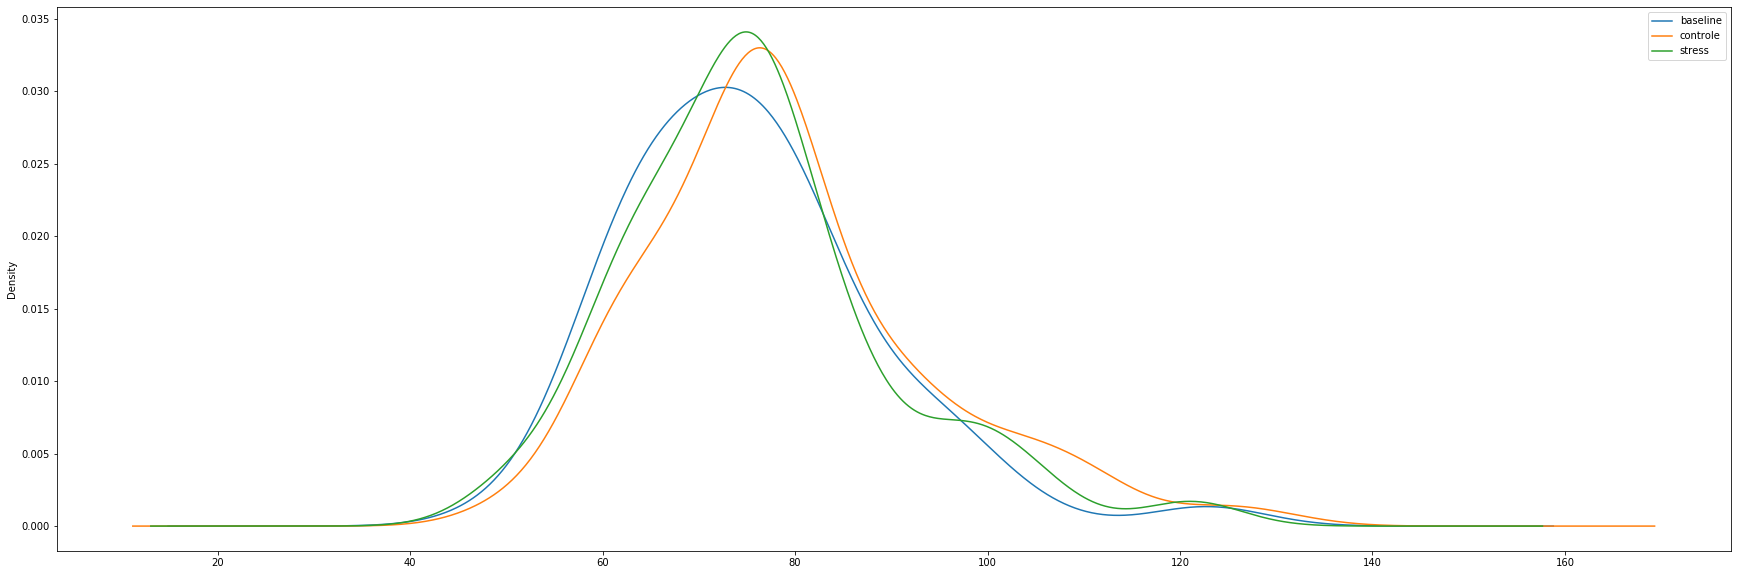

In [172]:
physio_mask = data.SCR_RATE.notna()
data_valid = data[physio_mask].copy()
data_valid["state_str"] = data_valid.fileNum.map(
    lambda x: state_mapping_dict.get(x, "DUNNO")
)

# for c in ['HRV', 'SCR_RATE', 'EDA']:
data_valid.groupby("state_str")["HR"].plot.kde(figsize=(30, 10), legend=True);

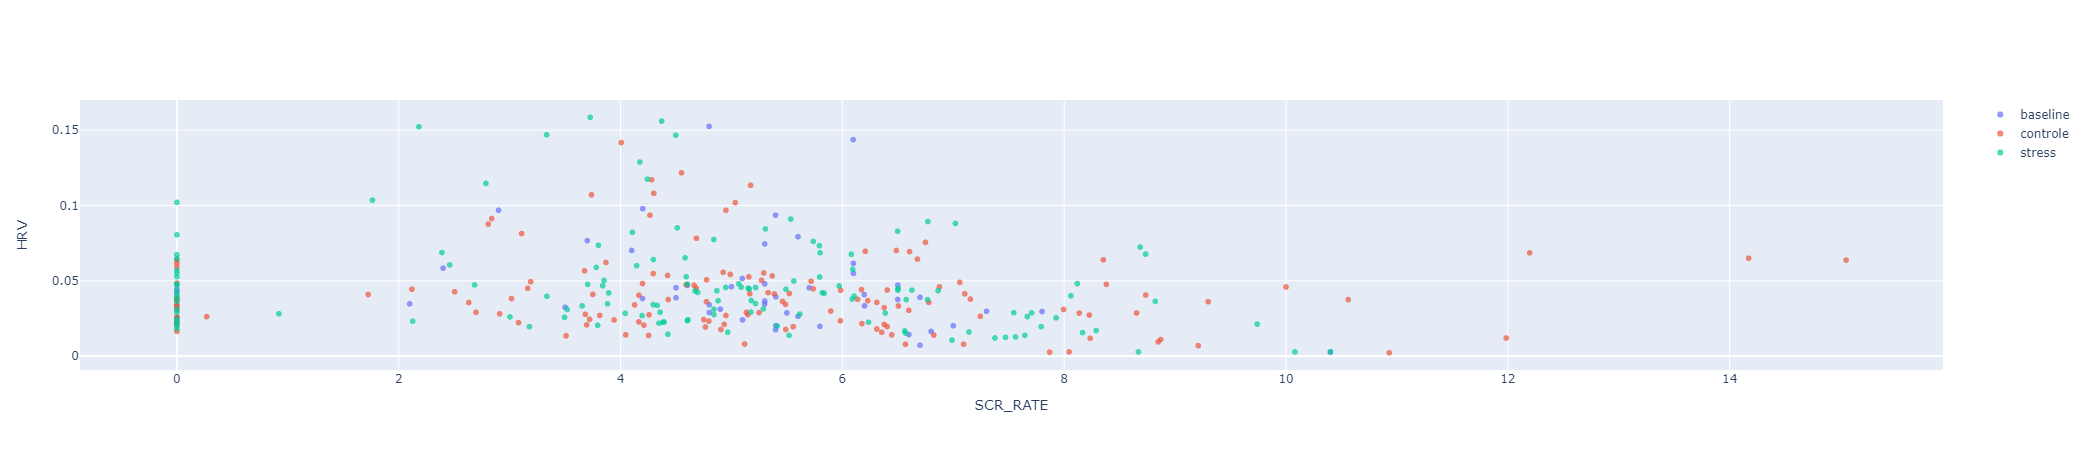

In [173]:
physio_mask = data.SCR_RATE.notna()
data_valid = data[physio_mask].copy()
data_valid["state_str"] = data_valid.fileNum.map(
    lambda x: state_mapping_dict.get(x, "DUNNO")
)

x_col = "SCR_RATE"
y_col = "HRV"


fig = go.Figure()
for state_str in data_valid.state_str.unique():
    data_valid_state = data_valid[data_valid.state_str == state_str]
    fig.add_trace(
        go.Scattergl(
            x=data_valid_state[x_col],
            y=data_valid_state[y_col],
            mode="markers",
            marker_opacity=0.7,
            name=state_str,
        )
    )
fig.update_xaxes(title=x_col)
fig.update_yaxes(title=y_col)

# Visualize some stuff

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# ax = sns.violinplot(x="fileNum", y="F0semitoneFrom27.5Hz_sma3nz_amean@NUMERIC", data=data)
# ax = sns.violinplot(x="fileNum", y="arousal", data=data)
# ax = sns.violinplot(x="fileNum", y="valence", data=data)
ax = sns.violinplot(x="fileNum", y="dominance", data=data)
